<a href="https://colab.research.google.com/github/bajay11/elderly-care-web-application/blob/main/GTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Files saved successfully in: /mnt/data


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


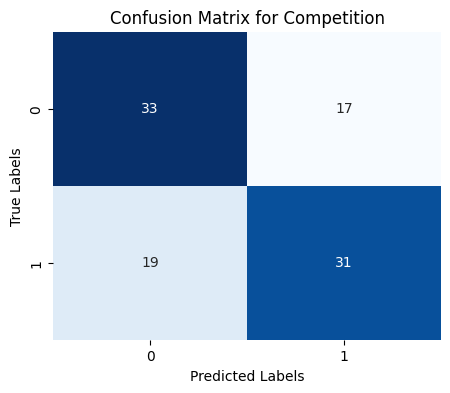

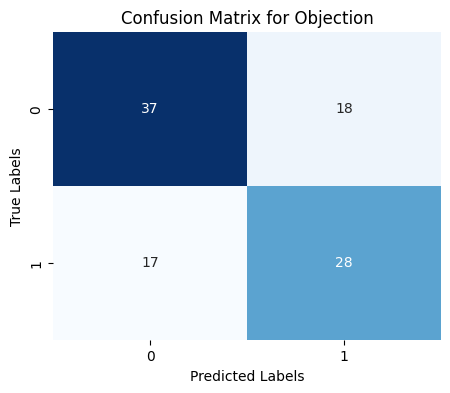

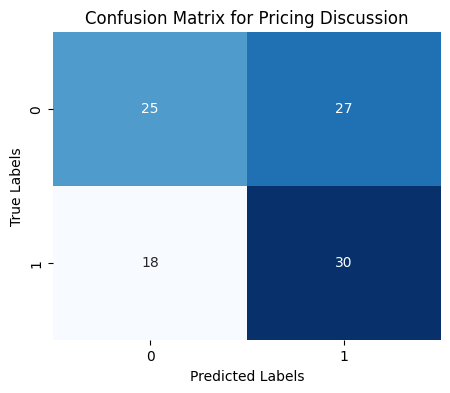

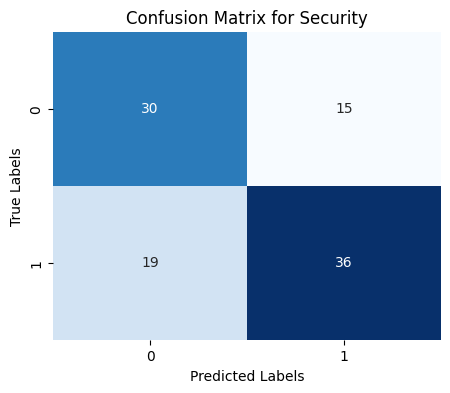

Classification Report:
                     precision    recall  f1-score   support

       Competition       0.65      0.62      0.63        50
         Objection       0.61      0.62      0.62        45
Pricing Discussion       0.53      0.62      0.57        48
          Security       0.71      0.65      0.68        55

         micro avg       0.62      0.63      0.62       198
         macro avg       0.62      0.63      0.62       198
      weighted avg       0.63      0.63      0.63       198
       samples avg       0.67      0.69      0.62       198



Your max_length is set to 50, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Cross-Validation F1 Scores: [0.65083007 0.63982846 0.68527977 0.67650745 0.5994149 ]
Mean F1 Score: 0.6503721295759517
Predicted Labels: ('Security',)
Extracted Entities: {
    "competitors": [
        "CompetitorX"
    ],
    "features": [
        "AI engine"
    ],
    "pricing_keywords": [
        "discount",
        "pricing model"
    ],
    "others": [
        "AI"
    ]
}
Summary: The pricing model of CompetitorX and their AI engine is worth discussing for a discount.


In [5]:
import pandas as pd
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import cross_val_score
import pickle
import spacy
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt_tab')

# Ensure required NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Task 1: Load and Prepare Data
# Load the dataset
calls_dataset = pd.read_csv("/content/calls_dataset_final.csv")

# Load domain knowledge base
domain_knowledge = {
    "competitors": ["CompetitorX", "CompetitorY", "CompetitorZ"],
    "features": ["analytics", "AI engine", "data pipeline"],
    "pricing_keywords": ["discount", "renewal cost", "budget", "pricing model"]
}

# Data Cleaning & Preprocessing
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = nltk.WordNetLemmatizer()

    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)

    # Tokenize text
    tokens = word_tokenize(text.lower())

    # Remove stopwords and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    return " ".join(cleaned_tokens)

calls_dataset['cleaned_text'] = calls_dataset['text_snippet'].apply(clean_text)

# Encode Labels for Multi-Label Classification
from sklearn.preprocessing import MultiLabelBinarizer

# Split the label column by commas
calls_dataset['labels_list'] = calls_dataset['labels'].apply(lambda x: [label.strip() for label in x.split(",")])

mlb = MultiLabelBinarizer()
labels_encoded = mlb.fit_transform(calls_dataset['labels_list'])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    calls_dataset['cleaned_text'], labels_encoded, test_size=0.2, random_state=42
)

# Text Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Model Training
classifier = MultiOutputClassifier(RandomForestClassifier(random_state=42))
classifier.fit(X_train_tfidf, y_train)

import os
import pickle

# Ensure the directory exists
output_dir = "/mnt/data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)  # Create the directory if it doesn't exist

# Save Processed Data and Model for Reuse
calls_dataset.to_csv(os.path.join(output_dir, "cleaned_calls_dataset.csv"), index=False)
with open(os.path.join(output_dir, "vectorizer.pkl"), "wb") as f:
    pickle.dump(vectorizer, f)
with open(os.path.join(output_dir, "classifier.pkl"), "wb") as f:
    pickle.dump(classifier, f)

print("Files saved successfully in:", output_dir)

# Load pre-trained spaCy model for NER
nlp = spacy.load("en_core_web_sm")

# Task 2: Entity/Keyword Extraction
def extract_entities(input_text, domain_knowledge, nlp):
    extracted_entities = {
        "competitors": [],
        "features": [],
        "pricing_keywords": [],
        "others": []
    }

    # Dictionary Lookup
    for key, keywords in domain_knowledge.items():
        for keyword in keywords:
            if keyword.lower() in input_text.lower():
                extracted_entities[key].append(keyword)

    # NER using spaCy
    doc = nlp(input_text)
    for ent in doc.ents:
        if ent.label_ in ["ORG", "PRODUCT", "MONEY"]:
            extracted_entities["others"].append(ent.text)

    # Remove duplicates
    for key in extracted_entities:
        extracted_entities[key] = list(set(extracted_entities[key]))

    return extracted_entities

# Task 3: Summarization
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize_text(input_text):
    summary = summarizer(input_text, max_length=50, min_length=10, do_sample=False)
    return summary[0]["summary_text"]

# Task 4: Unified Function
def process_text(input_text, vectorizer, classifier, mlb, domain_knowledge, nlp):
    # Predict Labels
    cleaned_text = clean_text(input_text)
    text_tfidf = vectorizer.transform([cleaned_text])
    predicted = classifier.predict(text_tfidf)
    predicted_labels = mlb.inverse_transform(predicted)[0]

    # Extract Entities
    entities = extract_entities(input_text, domain_knowledge, nlp)

    # Summarize Text
    summary = summarize_text(input_text)

    return {
        "predicted_labels": predicted_labels,
        "extracted_entities": entities,
        "summary": summary
    }

# Confusion Matrix and Visualization
conf_matrix = multilabel_confusion_matrix(y_test, classifier.predict(X_test_tfidf))
for i, label in enumerate(mlb.classes_):
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {label}')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# Classification Report
y_pred = classifier.predict(X_test_tfidf)
report = classification_report(y_test, y_pred, target_names=mlb.classes_)
print("Classification Report:\n", report)

# Cross-Validation
cv_scores = cross_val_score(classifier, X_train_tfidf, y_train, cv=5, scoring='f1_weighted')
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", cv_scores.mean())

# Example Usage
input_text = "The pricing model of CompetitorX and their AI engine is worth discussing for a discount."
results = process_text(input_text, vectorizer, classifier, mlb, domain_knowledge, nlp)

print("Predicted Labels:", results["predicted_labels"])
print("Extracted Entities:", json.dumps(results["extracted_entities"], indent=4))
print("Summary:", results["summary"])


In [4]:
# Ensure required NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True